In [1]:
from pathlib import Path
from typing import cast

import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2
import ml_project.data as d
import ml_project.helpers as h

## A bit of the context

Let's say we are observing packets in a connection between two hosts.

(Connection here is defined by (host1, port1, host2, port2, protocol))

(TODO: check that it is proper to use the word "connection" here)

---

A **forward packet** - a packet sent *from* the host that initiated the whole connection.

A **backward packet** - a packet sent *to* the host that initiated the whole connection.

---

**Inter-arrival time (IAT)** - the time between the arrival of two consecutive packets.

**Forward IAT** - the time between the observed arrival of two consecutive *forward* packets.

**Backward IAT** - the time between the observed arrival of two consecutive *backward* packets.

**Flow IAT** - the time between the observed arrival of any two consecutive packets.

---

**Flow** here is a sequence of packets, a time-limited slice of that connection.

**Flow timeout (FT)** is a set limit for the flow duration.

---

## Dataset

Each row in the table represents an aggregated information about one flow.

The FT for our data is supposed to be 15s. But we will see...

Worth mentioning that in the context of our problem the flow timeout is a parameter to how the input is computed in the first place. The model trained for the FT=15s should not be used on the input computed with FT=30s.

Another aggregation parameter is an idle timeout value - if the time of inactivity between packets is more than IT, then the stream considered idle.

The IT value for our data is unknown.

In [2]:
ds = d.Dataset(Path("../data/15s.arff"))
ds.orig.columns

Index(['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat',
       'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'pps', 'bps',
       'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat',
       'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle',
       'mean_idle', 'max_idle', 'std_idle', 'cls'],
      dtype='object')

## Features

**duration** - duration of the flow
- **unit:** microseconds
- **expected range:** 0 to FT
- `last.ts - first.ts`

**X_fiat** - summary statistics about Forward IATs in the flow
- **unit:** microseconds
- **expected range (single):** 0 to FT
- `X(new_forward.ts - last_forward.ts)`

**X_biat** - summary statistics about Backward IATs in the flow
- **unit:** microseconds
- **expected range (single):** 0 to FT
- `X(new_backward.ts - last_backward.ts)`

**X_flowiat** - summary statistics about Flow IATs in the flow
- **unit:** microseconds
- **expected range (single):** 0 to FT
- `X(new_any.ts - last_any.ts)`

**X_active/idle** - summary statistics about active/idle times
- **unit:** microseconds
- **expected range (single):** 0 to FT 

## Some pre-preparation

In [3]:
base = ds.orig.copy()
# Add temporary (or not) columns for the exploration purposes
base["packets"] = (base.duration.map(h.to_sec) * base.pps).astype(np.int64)
base["bytes"] = (base.duration.map(h.to_sec) * base.bps).astype(np.int64)
base.shape

(18758, 26)

# `duration`

In [4]:
h.desc_time(base.loc[:, ["duration"]])

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
duration,18758.0,9.791705,14.384581,0.0,0.0,0.000149,0.334669,11.092627,14.945371,14.999299,60.239488,601.404954


array([[<Axes: title={'center': 'duration'}>]], dtype=object)

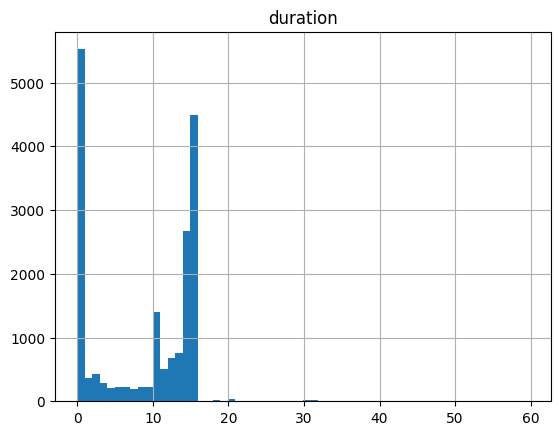

In [5]:
h.hist_time(base.loc[base.duration < h.s(60), ["duration"]], bins=60)

In [6]:
large_dur = base.loc[ds.orig.duration > h.s(15)]
large_dur

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,pps,...,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,cls,packets,bytes
991,61019409.0,411.0,1244.0,59957928.0,612962.0,3.813713e+06,6.322569e+04,15000000.0,1.514724e+05,0.557200,...,61000000.0,61019409.0,0.0,59957928.0,60000000.0,59957928.0,0.0,7,34,3971
1192,61018954.0,1004.0,1155.0,59957530.0,612953.0,3.813685e+06,6.322250e+04,15000000.0,1.514708e+05,0.557204,...,61000000.0,61018954.0,0.0,59957530.0,60000000.0,59957530.0,0.0,7,33,3971
1402,63449225.0,1976.0,18972.0,60394819.0,2905165.0,1.590000e+07,7.498888e+05,29700000.0,1.436921e+06,0.157606,...,31700000.0,60449670.0,40600000.0,2854910.0,31600000.0,60394819.0,40700000.0,7,10,873
1555,63449048.0,2879.0,18907.0,60395031.0,2909217.0,1.590000e+07,7.508910e+05,29700000.0,1.438954e+06,0.157607,...,31700000.0,60445484.0,40600000.0,2859193.0,31600000.0,60395031.0,40700000.0,7,9,872
1855,43002377.0,-1.0,43002377.0,-1.0,43002377.0,0.000000e+00,4.300000e+07,0.0,0.000000e+00,0.069764,...,43000000.0,43002377.0,0.0,42953129.0,43000000.0,42953129.0,0.0,7,3,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17114,59658852.0,1055.0,44.0,59552321.0,29109.0,1.490000e+07,1.457650e+04,29800000.0,2.055206e+04,0.134096,...,59700000.0,59658852.0,0.0,59552321.0,59600000.0,59552321.0,0.0,12,8,1464
17115,60380556.0,858.0,615.0,60284010.0,27705.0,1.510000e+07,1.416000e+04,30100000.0,1.915552e+04,0.132493,...,60400000.0,60380556.0,0.0,60284010.0,60300000.0,60284010.0,0.0,12,7,1463
17299,108780397.0,1170.0,83.0,108443099.0,106286.0,1.810000e+07,4.859520e+04,44200000.0,4.614519e+04,0.119507,...,109000000.0,108780397.0,0.0,108443099.0,108000000.0,108443099.0,0.0,12,12,1867
17756,61407952.0,1480.0,6704.0,61287812.0,51081.0,1.540000e+07,2.889250e+04,30600000.0,3.137928e+04,0.130276,...,61400000.0,61407952.0,0.0,61287812.0,61300000.0,61287812.0,0.0,12,7,1148


The data is supposedly prepared for FT=15s

And it doesn't look like we could use this data for FT>15s.

So, let's consider those 364 rows just an accident.

In [7]:
s15 = base.loc[base.duration <= h.s(15)]
s15.shape

(18394, 26)

<Axes: >

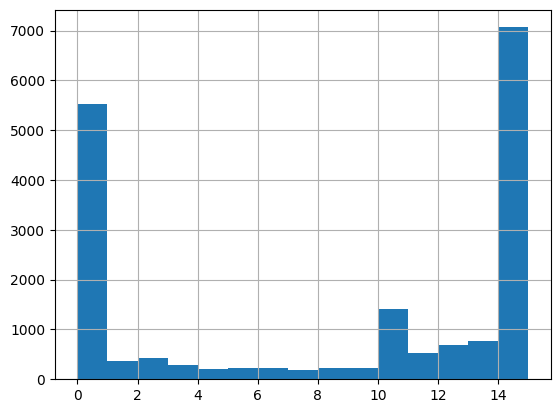

In [8]:
s15.duration.div(h.s(1)).hist(bins=15)

Now, let's look at the boundaries

In [9]:
s15.loc[s15.duration == h.s(0)].shape, s15.loc[s15.duration == h.s(15)].shape

((532, 26), (0, 26))

In [10]:
df = s15.loc[s15.duration == 0]
display(df.drop(columns="cls").value_counts().reset_index())
ds.class_fraction(df)

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,pps,...,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,packets,bytes,count
0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,0,0,532


,pop,pop_f,f
BROWSING (1),NaN,NaN,NaN
CHAT (2),2.0,0.4,0.2
STREAMING (3),31.0,5.8,6.4
MAIL (4),4.0,0.8,1.6
VOIP (5),6.0,1.1,0.2
P2P (6),7.0,1.3,0.7
FT (7),156.0,29.3,15.3
VPN-VOIP (8),6.0,1.1,0.3
VPN-CHAT (9),33.0,6.2,2.8
VPN-STREAMING (10),1.0,0.2,0.2


Theoretically, `duration==0` _can_ occur if the flow is just a few packets and they were registered at the same time.\
But why the most offen occurence here would be `VPN-P2P` - no idea.

To the trash bin it goes.

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
duration,17862.0,8.796656,6.31957,0.000002,0.00004,0.000855,0.490477,11.242503,14.92332,14.998721,14.999801,14.999998


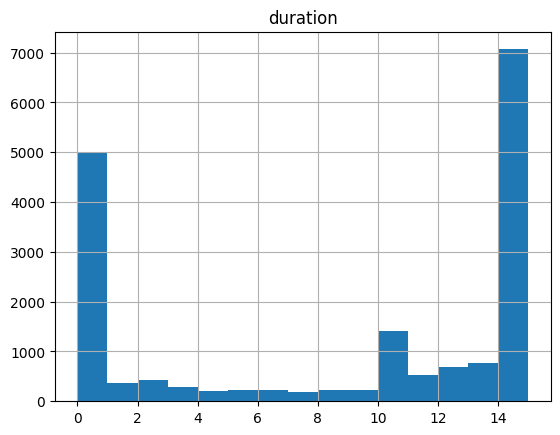

In [11]:
dur = s15.loc[s15.duration > 0]
h.hist_time(dur[["duration"]])
h.desc_time(dur[["duration"]])

## `packets`

In [12]:
pkt2 = dur.loc[dur.packets > 1]
pkt2.shape

(16676, 26)

## `X_active/idle`

Those statistics are computed as following:

- If there were long inactivity intervals (> `IT`) in the flow, then we have a sequence

  `active time 1` -> `idle time 1` -> `active time 2` -> `idle time 2` -> .....

  and then statistics are computed
- but if there were no such long inactivity intervals, then we don't have that sequence

  and have no statistics
  
  (at least it is what happens in that version of aggregation script which is available to us)

In [13]:
A_COLS = ["min_active", "max_active", "mean_active", "std_active"]
I_COLS = ["min_idle", "max_idle", "mean_idle", "std_idle"]
IDLE_COLS = A_COLS + I_COLS 
h.desc_time(pkt2[IDLE_COLS])

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
min_active,16676.0,1.638265,4.002134,-1.0,-1.0,-1.0,-1.0,-1.0,2.916699,10.224125,14.009787,14.999109
max_active,16676.0,2.438430,4.542712,-1.0,-1.0,-1.0,-1.0,-1.0,5.899142,10.498867,14.009787,14.999109
mean_active,16676.0,2.579503,3.745955,0.0,0.0,0.0,0.0,0.0,4.387310,10.200000,14.000000,15.000000
std_active,16676.0,0.467319,1.144079,0.0,0.0,0.0,0.0,0.0,0.000000,3.114372,5.346578,9.017990
min_idle,16676.0,1.345757,3.716855,-1.0,-1.0,-1.0,-1.0,-1.0,2.046784,10.000433,13.551158,14.983156
max_idle,16676.0,2.045985,4.195842,-1.0,-1.0,-1.0,-1.0,-1.0,4.886959,10.000601,13.577792,14.983156
mean_idle,16676.0,2.241318,3.461933,0.0,0.0,0.0,0.0,0.0,3.481792,10.000000,13.525000,15.000000
std_idle,16676.0,0.411562,1.058565,0.0,0.0,0.0,0.0,0.0,0.000000,2.869854,5.089500,9.000139


In [14]:
pkt2[IDLE_COLS].map(lambda x: -1 if x < 0 else 0 if x == 0 else 1).value_counts()

min_active  max_active  mean_active  std_active  min_idle  max_idle  mean_idle  std_idle
-1          -1          0            0           -1        -1        0          0           9681
 1           1          1            1            1         1        1          1           3777
                                     0            1         1        1          0           3218
Name: count, dtype: int64

In [15]:
df = pkt2.copy(deep=False)

# The case of no inactivity:
# - add no_idle flag
# - set min/max/mean active values to duration
# - set min/max/mean idle values to 0

no_idle = df.min_active < 0
df["no_idle"] = no_idle
df.loc[no_idle, ["min_active", "max_active", "mean_active"]] = df.duration
df.loc[no_idle, ["min_idle", "max_idle", "mean_idle"]] = 0
display(h.desc_time(df[IDLE_COLS]))

# Fix wierd rounding case

df = h.fix_mean_rounding(df, "active")
df = h.fix_mean_rounding(df, "idle")
display(h.desc_time(df.loc[:, IDLE_COLS]))
idle = df

h.check_stat_invariants(idle, "active")
h.check_stat_invariants(idle, "idle")

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
min_active,16676.0,6.918111,6.142742,0.000002,0.000089,0.023739,1.205517,4.241815,14.604468,14.998754,14.999799,14.999998
max_active,16676.0,7.718276,5.822580,0.000002,0.000089,0.023739,1.662857,7.329902,14.604468,14.998754,14.999799,14.999998
mean_active,16676.0,7.278813,5.931100,0.000002,0.000089,0.023739,1.620904,5.370560,14.600000,14.998770,14.999818,15.000000
std_active,16676.0,0.467319,1.144079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.114372,5.346578,9.017990
min_idle,16676.0,1.926292,3.366717,0.000000,0.000000,0.000000,0.000000,0.000000,2.046784,10.000433,13.551158,14.983156
max_idle,16676.0,2.626520,3.783095,0.000000,0.000000,0.000000,0.000000,0.000000,4.886959,10.000601,13.577792,14.983156
mean_idle,16676.0,2.241318,3.461933,0.000000,0.000000,0.000000,0.000000,0.000000,3.481792,10.000000,13.525000,15.000000
std_idle,16676.0,0.411562,1.058565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.869854,5.089500,9.000139


fix mean rounding for active
OK: std_active == 0
OK: mean_active == rount_time(min_active)
FAIL: min == max and min != mean


,min_active,max_active,mean_active,std_active


fix mean rounding for idle
OK: std_idle == 0
OK: mean_idle == rount_time(min_idle)
FAIL: min == max and min != mean


,min_idle,max_idle,mean_idle,std_idle


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
min_active,16676.0,6.918111,6.142742,0.000002,0.000089,0.023739,1.205517,4.241815,14.604468,14.998754,14.999799,14.999998
max_active,16676.0,7.718276,5.822580,0.000002,0.000089,0.023739,1.662857,7.329902,14.604468,14.998754,14.999799,14.999998
mean_active,16676.0,7.280491,5.931829,0.000002,0.000089,0.023739,1.620904,5.370560,14.604468,14.998754,14.999799,14.999998
std_active,16676.0,0.467319,1.144079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.114372,5.346578,9.017990
min_idle,16676.0,1.926292,3.366717,0.000000,0.000000,0.000000,0.000000,0.000000,2.046784,10.000433,13.551158,14.983156
max_idle,16676.0,2.626520,3.783095,0.000000,0.000000,0.000000,0.000000,0.000000,4.886959,10.000601,13.577792,14.983156
mean_idle,16676.0,2.241384,3.462045,0.000000,0.000000,0.000000,0.000000,0.000000,3.481792,10.000433,13.551158,14.983156
std_idle,16676.0,0.411562,1.058565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.869854,5.089500,9.000139


OK: min_active <= mean_active
OK: mean_active <= max_active
OK: min_active == max_active => std_active == 0
OK: std_active == 0 => min_active == max_active
OK: min_idle <= mean_idle
OK: mean_idle <= max_idle
OK: min_idle == max_idle => std_idle == 0
OK: std_idle == 0 => min_idle == max_idle


In [16]:
idle[IDLE_COLS].map(lambda x: -1 if x < 0 else 0 if x == 0 else 1).value_counts()

min_active  max_active  mean_active  std_active  min_idle  max_idle  mean_idle  std_idle
1           1           1            0           0         0         0          0           9681
                                     1           1         1         1          1           3777
                                     0           1         1         1          0           3218
Name: count, dtype: int64

array([[<Axes: title={'center': 'min_idle'}>,
        <Axes: title={'center': 'max_idle'}>],
       [<Axes: title={'center': 'mean_idle'}>,
        <Axes: title={'center': 'std_idle'}>]], dtype=object)

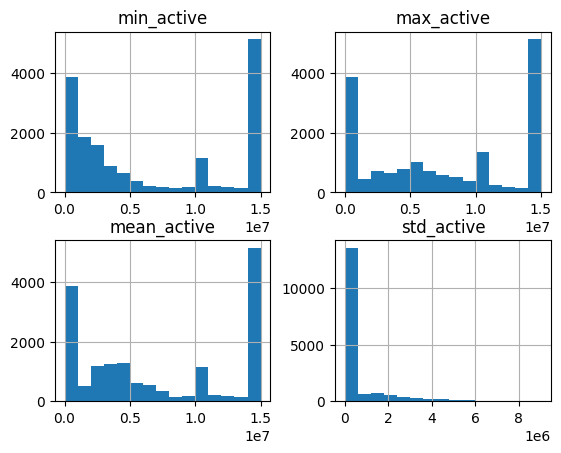

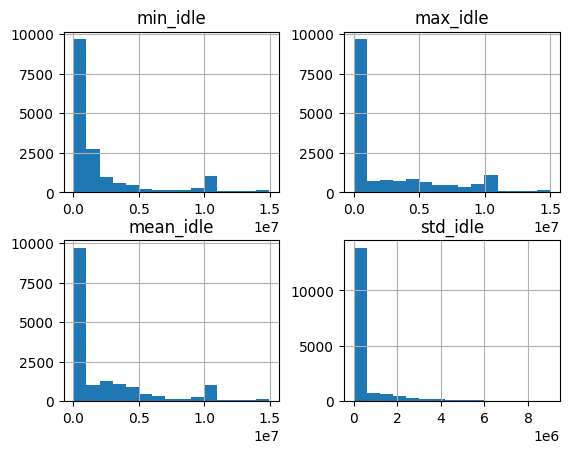

In [17]:
idle[A_COLS].hist(bins=15)
idle[I_COLS].hist(bins=15)

## `X_Yiat`

In [18]:
df = idle
h.check_stat_invariants(df, "fiat", with_std=False)
h.check_stat_invariants(df, "biat", with_std=False)

FAIL: min_fiat <= mean_fiat


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,pps,...,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,cls,packets,bytes,no_idle
0,9368711.0,16.0,4.0,1564818.0,1549373.0,1.902053e+05,2.032905e+05,389822.391917,370323.719754,10.353612,...,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,2,97,44995,False
1,7340238.0,18.0,4.0,1567554.0,1527893.0,1.656870e+05,1.869148e+05,317267.548742,304370.651301,11.580006,...,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,2,84,31857,False
2,4644225.0,29.0,15.0,1270547.0,1079974.0,1.658652e+05,1.953021e+05,329473.126261,300492.588227,11.412022,...,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,2,53,19327,False
3,4978735.0,19.0,8.0,2492050.0,2457286.0,2.395432e+05,2.765964e+05,612435.304238,628339.573544,8.034169,...,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,2,39,19510,False
4,11838189.0,19.0,10.0,3094089.0,3093543.0,2.437665e+05,2.959547e+05,599721.781709,625632.703972,7.602514,...,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,2,89,33176,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18261,14253939.0,7002496.0,6995059.0,7006795.0,7042458.0,7.004646e+06,7.018758e+06,3039.851888,33516.154307,0.420936,...,7006795.0,3.039852e+03,6790373.0,6794091.5,6797810.0,5258.753037,6,5,713,False
18264,14207249.0,6998355.0,6991367.0,7015795.0,6997997.0,7.007075e+06,6.994682e+06,12331.942223,4688.117853,0.422320,...,7015795.0,1.233194e+04,6797910.0,6801404.0,6804898.0,4941.262086,6,6,713,False
18428,7001469.0,7001469.0,-1.0,7001469.0,-1.0,7.001469e+06,0.000000e+00,0.000000,0.000000,0.428482,...,7001469.0,0.000000e+00,6912268.0,6912268.0,6912268.0,0.000000,6,3,579,False
18491,13992916.0,6994446.0,-1.0,6998470.0,-1.0,6.996458e+06,0.000000e+00,2845.397512,0.000000,0.285859,...,6998470.0,2.845398e+03,6835975.0,6917222.5,6998470.0,114901.316405,6,3,709,False


FAIL: mean_fiat <= max_fiat


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,pps,...,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,cls,packets,bytes,no_idle
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,2,97,44995,False
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,2,84,31857,False
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,2,53,19327,False
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,2,39,19510,False
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,2,89,33176,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18186,200759.0,88.0,0.0,99988.0,100746.0,50038.000000,33620.333333,70639.967433,58132.561012,34.867677,...,200759.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,7,826,True
18189,177893.0,144.0,27.0,88600.0,89333.0,44372.000000,29801.000000,62547.837429,51556.224954,39.349497,...,177893.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,6,825,True
18190,191936.0,72.0,20.0,89429.0,102548.0,44750.500000,34199.666667,63184.940639,59191.393224,36.470490,...,191936.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,7,819,True
18191,176700.0,78.0,47.0,87799.0,88860.0,43938.500000,29664.666667,62028.113944,51264.666349,39.615167,...,176700.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,6,826,True


FAIL: min_biat <= mean_biat


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,pps,...,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,cls,packets,bytes,no_idle
0,9368711.0,16.0,4.0,1564818.0,1549373.0,1.902053e+05,2.032905e+05,3.898224e+05,3.703237e+05,10.353612,...,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,1.610965e+05,2,97,44995,False
1,7340238.0,18.0,4.0,1567554.0,1527893.0,1.656870e+05,1.869148e+05,3.172675e+05,3.043707e+05,11.580006,...,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,2.731384e+05,2,84,31857,False
2,4644225.0,29.0,15.0,1270547.0,1079974.0,1.658652e+05,1.953021e+05,3.294731e+05,3.004926e+05,11.412022,...,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000e+00,2,53,19327,False
3,4978735.0,19.0,8.0,2492050.0,2457286.0,2.395432e+05,2.765964e+05,6.124353e+05,6.283396e+05,8.034169,...,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,7.749303e+05,2,39,19510,False
4,11838189.0,19.0,10.0,3094089.0,3093543.0,2.437665e+05,2.959547e+05,5.997218e+05,6.256327e+05,7.602514,...,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,7.259878e+05,2,89,33176,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18191,176700.0,78.0,47.0,87799.0,88860.0,4.393850e+04,2.966467e+04,6.202811e+04,5.126467e+04,39.615167,...,176700.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,6,6,826,True
18192,176843.0,82.0,51.0,88121.0,88696.0,4.410150e+04,2.960633e+04,6.225297e+04,5.117315e+04,39.583133,...,176843.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,6,6,818,True
18196,8712389.0,1990162.0,1988563.0,6608031.0,6609078.0,4.299096e+06,4.298820e+06,3.265326e+06,3.267197e+06,0.688674,...,6608031.0,3.265326e+06,1875414.0,4185148.0,6494882.0,3.266457e+06,6,5,834,False
18261,14253939.0,7002496.0,6995059.0,7006795.0,7042458.0,7.004646e+06,7.018758e+06,3.039852e+03,3.351615e+04,0.420936,...,7006795.0,3.039852e+03,6790373.0,6794091.5,6797810.0,5.258753e+03,6,5,713,False


FAIL: mean_biat <= max_biat


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,pps,...,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,cls,packets,bytes,no_idle
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,2,97,44995,False
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,2,84,31857,False
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,2,53,19327,False
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,2,39,19510,False
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,2,89,33176,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18186,200759.0,88.0,0.0,99988.0,100746.0,50038.000000,33620.333333,70639.967433,58132.561012,34.867677,...,200759.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,7,826,True
18189,177893.0,144.0,27.0,88600.0,89333.0,44372.000000,29801.000000,62547.837429,51556.224954,39.349497,...,177893.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,6,825,True
18190,191936.0,72.0,20.0,89429.0,102548.0,44750.500000,34199.666667,63184.940639,59191.393224,36.470490,...,191936.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,7,819,True
18191,176700.0,78.0,47.0,87799.0,88860.0,43938.500000,29664.666667,62028.113944,51264.666349,39.615167,...,176700.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,6,826,True


In [19]:
df = idle
display({
    "all": df.shape,
    "tf < minf": df.loc[df.total_fiat.le(df.min_fiat)].shape,
    "minf > maxf": df.loc[df.min_fiat.ge(df.max_fiat) | df.min_fiat.lt(0)].shape,
    "tb < minb": df.loc[df.total_fiat.le(df.min_fiat)].shape,
    "minb > maxb": df.loc[df.min_biat.ge(df.max_biat) | df.min_biat.lt(0)].shape,
})
# It looks like the column names are wrong
# Let's rename
yiat_named = idle.rename(columns={
    "total_fiat": "min_fiat",
    "min_fiat": "max_fiat",
    "max_fiat": "mean_fiat",
    "mean_fiat": "std_fiat",
    "total_biat": "min_biat",
    "min_biat": "max_biat",
    "max_biat": "mean_biat",
    "mean_biat": "std_biat",
})

{'all': (16676, 27),
 'tf < minf': (16676, 27),
 'minf > maxf': (16638, 27),
 'tb < minb': (16676, 27),
 'minb > maxb': (16604, 27)}

In [20]:
FIAT_COLS = h.stats("fiat")
BIAT_COLS = h.stats("biat")
YIAT_COLS = FIAT_COLS + BIAT_COLS
h.desc_time(yiat_named.loc[:, YIAT_COLS])

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
min_fiat,16676.0,0.592114,2.352355,-1.0,-1.0,-1.0,0.000014,0.000076,0.005519,9.251490,10.039741,14.983442
max_fiat,16676.0,2.569981,3.706244,-1.0,-1.0,-1.0,0.035437,0.523151,4.649085,10.039208,13.415987,14.983442
mean_fiat,16676.0,0.950693,2.358791,0.0,0.0,0.0,0.018343,0.098805,0.576259,9.251490,10.000000,15.000000
std_fiat,16676.0,0.559698,1.151971,0.0,0.0,0.0,0.001790,0.019243,0.696652,2.721644,5.466847,10.600000
min_biat,16676.0,0.585089,2.479674,-1.0,-1.0,-1.0,0.000003,0.000028,0.005674,10.037954,10.039994,14.983377
max_biat,16676.0,2.602183,3.798208,-1.0,-1.0,-1.0,0.031121,0.596412,4.808200,10.039216,13.514184,14.983377
mean_biat,16676.0,0.984435,2.457148,0.0,0.0,0.0,0.017045,0.076727,0.595483,10.000000,10.000000,15.000000
std_biat,16676.0,0.556561,1.124537,0.0,0.0,0.0,0.001356,0.022724,0.666592,2.827645,5.245245,10.600000


In [21]:
df = yiat_named.copy(deep=False)

# If "absent" - maybe it means there were only backward packets
for Y in [FIAT_COLS, BIAT_COLS]:
    iat = Y[0].split("_")[1]
    no_iat = df[f"min_{iat}"] < 0
    display(h.desc_time(df.loc[no_iat, Y]))

    df[f"no_{iat}"] = no_iat
    df.loc[no_iat, f"min_{iat}"] = 0
    df.loc[no_iat, f"max_{iat}"] = 0


df = h.fix_mean_rounding(df, "fiat")
df = h.fix_mean_rounding(df, "biat")

yiat = df
display(h.desc_time(yiat.loc[:, YIAT_COLS]))

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
min_fiat,1227.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
max_fiat,1227.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
mean_fiat,1227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_fiat,1227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
min_biat,1909.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
max_biat,1909.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
mean_biat,1909.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_biat,1909.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


fix mean rounding for fiat
OK: std_fiat == 0
OK: mean_fiat == rount_time(min_fiat)
FAIL: min == max and min != mean


,min_fiat,max_fiat,mean_fiat,std_fiat


fix mean rounding for biat
OK: std_biat == 0
OK: mean_biat == rount_time(min_biat)
FAIL: min == max and min != mean


,min_biat,max_biat,mean_biat,std_biat


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
min_fiat,16676.0,0.665693,2.316773,0.0,0.0,0.0,0.000014,0.000076,0.005519,9.251490,10.039741,14.983442
max_fiat,16676.0,2.643560,3.644041,0.0,0.0,0.0,0.035437,0.523151,4.649085,10.039208,13.415987,14.983442
mean_fiat,16676.0,0.952393,2.365302,0.0,0.0,0.0,0.018343,0.098805,0.576259,9.251490,10.039741,14.983442
std_fiat,16676.0,0.559698,1.151971,0.0,0.0,0.0,0.001790,0.019243,0.696652,2.721644,5.466847,10.600000
min_biat,16676.0,0.699565,2.426362,0.0,0.0,0.0,0.000003,0.000028,0.005674,10.037954,10.039994,14.983377
max_biat,16676.0,2.716659,3.701754,0.0,0.0,0.0,0.031121,0.596412,4.808200,10.039216,13.514184,14.983377
mean_biat,16676.0,0.986093,2.463187,0.0,0.0,0.0,0.017045,0.076727,0.595483,10.037954,10.039994,14.983377
std_biat,16676.0,0.556561,1.124537,0.0,0.0,0.0,0.001356,0.022724,0.666592,2.827645,5.245245,10.600000


array([[<Axes: title={'center': 'min_biat'}>,
        <Axes: title={'center': 'max_biat'}>],
       [<Axes: title={'center': 'mean_biat'}>,
        <Axes: title={'center': 'std_biat'}>]], dtype=object)

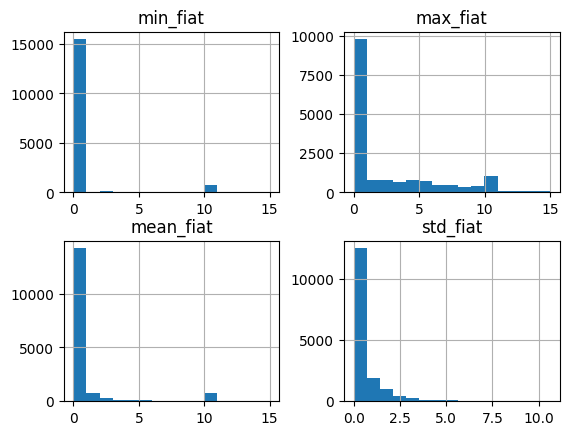

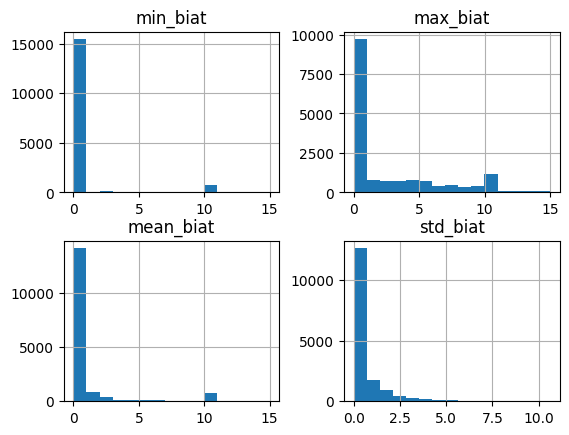

In [22]:
yiat[FIAT_COLS].div(h.s(1)).hist(bins=15)
yiat[BIAT_COLS].div(h.s(1)).hist(bins=15)

## `X_flowiat`

In [23]:
FLIAT_COLS = ["min_flowiat", "max_flowiat", "mean_flowiat", "std_flowiat"]

h.desc_time(yiat.loc[:, FLIAT_COLS])

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
min_flowiat,16676.0,-0.780914,18.236213,-1247.000000,-1.000000,0.000000,0.000003,0.000016,0.000089,0.052816,0.285784,14.155903
max_flowiat,16676.0,2.756543,3.700559,0.000002,0.000085,0.016508,0.031730,0.678185,4.886959,10.000601,13.577792,14.983156
mean_flowiat,16676.0,0.408541,0.891263,0.000002,0.000055,0.000418,0.009937,0.087676,0.327127,3.358906,3.360667,14.200000
std_flowiat,16676.0,0.795597,1.492095,0.000000,0.000000,0.000000,0.006884,0.135053,0.816635,5.750605,5.751732,10.600000


In [24]:
# When forward and backward packets arrive at about the same time,
# there is no guaranty in how their timestamps will be set.
# And no guaranty that they will be ordered exactly by the timestamp in the packet trace.

df = yiat.copy(deep=False
)
confused_flowiat = df.min_flowiat < 0

df.loc[confused_flowiat, "min_flowiat"] = 0

flowiat = df
h.desc_time(df.loc[:, FLIAT_COLS])

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
min_flowiat,16676.0,0.022696,0.257388,0.000000,0.000000,0.000000,0.000003,0.000016,0.000089,0.052816,0.285784,14.155903
max_flowiat,16676.0,2.756543,3.700559,0.000002,0.000085,0.016508,0.031730,0.678185,4.886959,10.000601,13.577792,14.983156
mean_flowiat,16676.0,0.408541,0.891263,0.000002,0.000055,0.000418,0.009937,0.087676,0.327127,3.358906,3.360667,14.200000
std_flowiat,16676.0,0.795597,1.492095,0.000000,0.000000,0.000000,0.006884,0.135053,0.816635,5.750605,5.751732,10.600000


array([[<Axes: title={'center': 'min_flowiat'}>,
        <Axes: title={'center': 'max_flowiat'}>],
       [<Axes: title={'center': 'mean_flowiat'}>,
        <Axes: title={'center': 'std_flowiat'}>]], dtype=object)

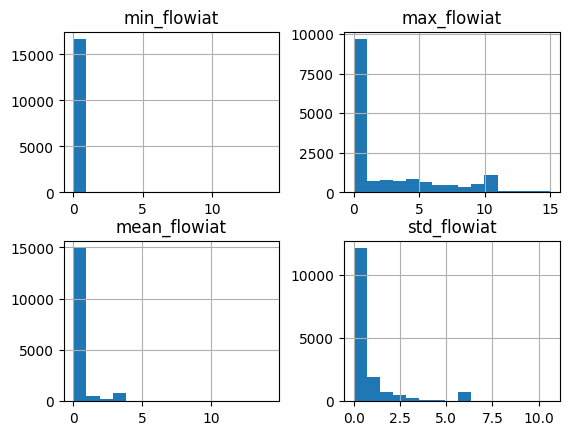

In [25]:
flowiat[FLIAT_COLS].div(h.s(1)).hist(bins=15)

In [26]:
fin = flowiat.drop(columns=["packets", "bytes"])
display(ds.class_fraction(fin))
fin.to_csv("../data/filtered.csv", index=False)
fin

,pop,pop_f,f
BROWSING (1),2290,13.7,91.6
CHAT (2),770,4.6,86.5
STREAMING (3),389,2.3,80.7
MAIL (4),215,1.3,86.3
VOIP (5),2820,16.9,99.8
P2P (6),627,3.8,62.7
FT (7),822,4.9,80.7
VPN-VOIP (8),2255,13.5,99.3
VPN-CHAT (9),1091,6.5,91.2
VPN-STREAMING (10),412,2.5,86.7


,duration,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,std_fiat,std_biat,pps,...,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,cls,no_idle,no_fiat,no_biat
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,2,False,False,False
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,2,False,False,False
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,2,False,False,False
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,2,False,False,False
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,2,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18739,237026.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,8.437893,...,237026.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,True,True,True
18748,181300.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,11.031440,...,181300.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,True,True,True
18754,52083.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,38.400246,...,52083.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,True,True,True
18755,67923.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,29.445107,...,67923.0,0.000000e+00,0.0,0.0,0.0,0.000000,6,True,True,True
